In [25]:
# Cell 1: Import necessary libraries
import pyrosetta
import numpy as np
import requests
import os
import json

from pyrosetta.rosetta.core.kinematics import MoveMap
from pyrosetta.rosetta.protocols.simple_moves import SmallMover
from pyrosetta.rosetta.protocols.minimization_packing import MinMover
from pyrosetta.rosetta.core.scoring import ScoreFunction
from pyrosetta.rosetta.protocols.relax import FastRelax

In [39]:
# Cell 2: Function to fetch PDB info (with improved search)
def fetch_pdb_info(search_term, apo=False):
    url = "https://search.rcsb.org/rcsbsearch/v2/query"
    query = {
        "query": {
            "type": "group",
            "logical_operator": "and",
            "nodes": [
                {
                    "type": "terminal",
                    "service": "text",
                    "parameters": {
                        "attribute": "rcsb_entity_source_organism.rcsb_gene_name.value",
                        "operator": "exact_match",
                        "value": search_term
                    }
                }
            ]
        },
        "return_type": "entry",
        "request_options": {
            "return_all_hits": True
        }
    }
    
    try:
        response = requests.post(url, json=query)
        response.raise_for_status()
        
        data = response.json()
        
        if data['total_count'] > 0:
            if apo:
                # Filter for apo structures (those without ligands)
                apo_structures = [entry['identifier'] for entry in data['result_set'] 
                                  if not any('has_ligands' in group and group['has_ligands'] == 'Y' 
                                             for group in entry.get('group_list', []))]
                if apo_structures:
                    return apo_structures[0]  # Return the first apo structure found
                else:
                    print("No apo structures found.")
                    return None
            else:
                return data['result_set'][0]['identifier']
        else:
            print(f"No results found for search term: {search_term}")
            return None
    except requests.exceptions.RequestException as req_err:
        print(f"Request Exception: {req_err}")
        return None
    except json.JSONDecodeError as json_err:
        print(f"JSON Decode Error: {json_err}")
        print(f"Response content: {response.text}")
        return None


In [41]:
# Cell 4: Fetch and download PDB
search_term = "AraC"
pdb_id = fetch_pdb_info(search_term)
if pdb_id:
    pdb_path = download_pdb(pdb_id)
    print(f"Downloaded PDB file: {pdb_path}")
else:
    print(f"No PDB found for {search_term}")
    raise ValueError("PDB not found")

Downloaded PDB file: ./1XJA.pdb


In [42]:
# Cell 5: Initialize PyRosetta
pyrosetta.init()

┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.Release.python39.m1 2024.24+release.ca096dac4f43ee5ee195f87f3703a520fcf60cf9 2024-06-14T16:57:57] retrieved from: http://www.pyrosetta.org
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.Release.python39.m1 r384 2024.24+release.ca096dac4f ca096dac4f43ee5ee195

In [43]:
# Cell 6: Load and prepare the PDB
def prepare_pdb(pdb_file, output_file):
    with open(pdb_file, 'r') as f:
        lines = f.readlines()
    
    # Filter lines to keep only protein atoms and the first chain
    filtered_lines = [line for line in lines if line.startswith('ATOM') and line[21] == 'A']
    
    with open(output_file, 'w') as f:
        f.writelines(filtered_lines)

    return output_file

prepared_pdb = prepare_pdb(pdb_path, 'prepared_arac.pdb')

In [44]:
# Cell 7: Load the prepared PDB into PyRosetta
pose = pyrosetta.pose_from_pdb(prepared_pdb)


core.import_pose.import_pose: File 'prepared_arac.pdb' automatically determined to be of type PDB
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue LYS 36
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue LYS 36
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CE  on residue LYS 36
core.conformation.Conformation: [ WARNING ] missing heavyatom:  NZ  on residue LYS 36
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue ARG 92
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue ARG 92
core.conformation.Conformation: [ WARNING ] missing heavyatom:  NE  on residue ARG 92
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CZ  on residue ARG 92
core.conformation.Conformation: [ WARNING ] missing heavyatom:  NH1 on residue ARG 92
core.conformation.Conformation: [ WARNING ] missing heavyatom:  NH2 on residue ARG 92
core.conformation.Conformation: [ WARNING 

In [45]:
# Cell 8: Set up MoveMap for N-terminal residues
movemap = MoveMap()
for i in range(1, 16):  # First 15 residues
    movemap.set_bb(i, True)
    movemap.set_chi(i, True)

In [46]:
# Cell 9: Set up scoring function
scorefxn = pyrosetta.get_fa_scorefxn()

core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015


In [47]:
# Cell 10: Set up movers
small_mover = SmallMover(movemap, 1.0, 1)
min_mover = MinMover()
min_mover.movemap(movemap)
min_mover.score_function(scorefxn)

In [48]:
# Cell 11: Set up FastRelax
relax = FastRelax()
relax.set_scorefxn(scorefxn)
relax.set_movemap(movemap)

core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015


In [49]:
# Cell 12: Perform ab initio search
def perform_abinito_search(pose, num_cycles=10):
    for _ in range(num_cycles):
        small_mover.apply(pose)
        min_mover.apply(pose)
    
    relax.apply(pose)
    return pose

In [50]:
# Cell 13: Run the search
final_pose = perform_abinito_search(pose.clone())

protocols.relax.FastRelax: CMD: repeat  -14.9792  0  0  0.55
protocols.relax.FastRelax: CMD: coord_cst_weight  -14.9792  0  0  0.55
protocols.relax.FastRelax: CMD: scale:fa_rep  -247.792  0  0  0.022
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 4036 rotamers at 165 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.relax.FastRelax: CMD: repack  -487.072  0  0  0.022
protocols.relax.FastRelax: CMD: scale:fa_rep  -480.157  0  0  0.02805
protocols.relax.FastRelax: CMD: min  -484.069  0.135819  0.135819  0.02805
protocols.relax.FastRelax: CMD: coord_cst_weight  -484.069  0.135819  0.135819  0.02805
protocols.relax.FastRelax: CMD: scale:fa_rep  -346.855  0.135819  0.135819  0.14575
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 3717 rotamers at 165 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDIntera

In [51]:
# Cell 14: Fetch and download apo form PDB
apo_pdb_id = fetch_pdb_info("AraC", apo=True)
if apo_pdb_id:
    apo_pdb_path = download_pdb(apo_pdb_id)
    print(f"Downloaded apo PDB file: {apo_pdb_path}")
else:
    print("No apo PDB found for AraC")
    raise ValueError("Apo PDB not found")

Downloaded apo PDB file: ./1XJA.pdb


In [52]:
# Cell 15: Load apo form and calculate RMSD
apo_pose = pyrosetta.pose_from_pdb(apo_pdb_path)

def calculate_rmsd(pose1, pose2):
    return pyrosetta.rosetta.core.scoring.CA_rmsd(pose1, pose2)

rmsd = calculate_rmsd(final_pose, apo_pose)

print(f"RMSD between predicted structure and apo form: {rmsd:.2f} Å")

core.import_pose.import_pose: File './1XJA.pdb' automatically determined to be of type PDB
core.chemical.GlobalResidueTypeSet: Loading (but possibly not actually using) 'EDO' from the PDB components dictionary for residue type 'pdb_EDO'
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue LYS 36
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue LYS 36
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CE  on residue LYS 36
core.conformation.Conformation: [ WARNING ] missing heavyatom:  NZ  on residue LYS 36
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue ARG 92
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue ARG 92
core.conformation.Conformation: [ WARNING ] missing heavyatom:  NE  on residue ARG 92
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CZ  on residue ARG 92
core.conformation.Conformation: [ WARNING ] missing heavyatom:  NH1 on resi

In [53]:
# Cell 16: Save the final structure
final_pose.dump_pdb('final_arac_structure.pdb')

True

In [55]:
# Cell 17: Visualize results (using py3Dmol)
import py3Dmol

def visualize_structures(initial_pdb, predicted_pdb, apo_pdb, labels):
    view = py3Dmol.view(width=1200, height=400)
    
    # Load the initial structure
    view.addModel(open(initial_pdb, 'r').read(), 'pdb')
    view.setStyle({'model': -1}, {'cartoon': {'color': 'spectrum'}})
    
    # Load the predicted structure
    view.addModel(open(predicted_pdb, 'r').read(), 'pdb')
    view.setStyle({'model': -1}, {'cartoon': {'color': 'spectrum'}})
    
    # Load the apo structure
    view.addModel(open(apo_pdb, 'r').read(), 'pdb')
    view.setStyle({'model': -1}, {'cartoon': {'color': 'spectrum'}})
    
    # Add labels
    view.addLabel(labels[0], {'position': {'x': -40, 'y': 0, 'z': 0}, 'backgroundColor': 'white', 'fontColor': 'black'})
    view.addLabel(labels[1], {'position': {'x': 0, 'y': 0, 'z': 0}, 'backgroundColor': 'white', 'fontColor': 'black'})
    view.addLabel(labels[2], {'position': {'x': 40, 'y': 0, 'z': 0}, 'backgroundColor': 'white', 'fontColor': 'black'})
    
    view.zoomTo()
    return view

# Assuming 'prepared_arac.pdb' is the initial structure
view = visualize_structures('prepared_arac.pdb', 'final_arac_structure.pdb', apo_pdb_path, 
                            ['Initial Structure', 'Predicted Structure', 'Apo Structure'])
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

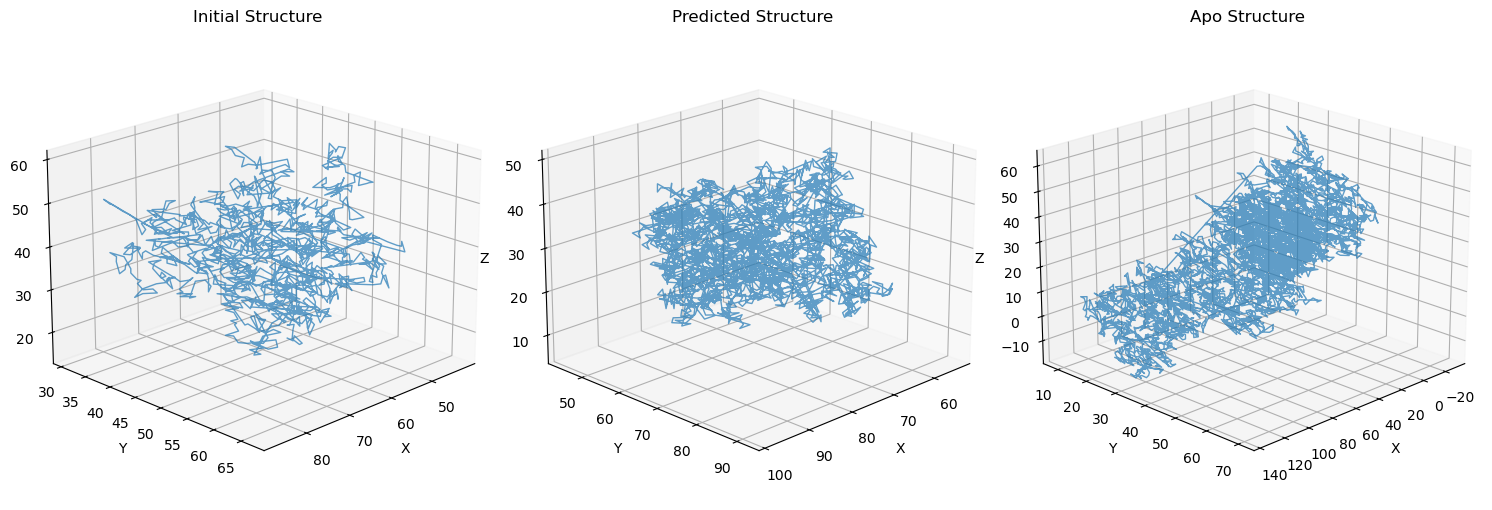

In [57]:
# Cell 17: Visualize results (using matplotlib)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def parse_pdb(filename):
    with open(filename, 'r') as file:
        atoms = []
        for line in file:
            if line.startswith('ATOM'):
                x = float(line[30:38])
                y = float(line[38:46])
                z = float(line[46:54])
                atoms.append((x, y, z))
    return np.array(atoms)

def visualize_structures(initial_pdb, predicted_pdb, apo_pdb, labels):
    fig = plt.figure(figsize=(15, 5))
    
    structures = [initial_pdb, predicted_pdb, apo_pdb]
    
    for i, (pdb, label) in enumerate(zip(structures, labels)):
        ax = fig.add_subplot(1, 3, i+1, projection='3d')
        atoms = parse_pdb(pdb)
        
        ax.plot(atoms[:, 0], atoms[:, 1], atoms[:, 2], '-', lw=1, alpha=0.7)
        ax.set_title(label)
        
        # Set consistent viewing angle and zoom
        ax.view_init(elev=20, azim=45)
        ax.dist = 10
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        
    plt.tight_layout()
    plt.show()

# Assuming 'prepared_arac.pdb' is the initial structure
visualize_structures('prepared_arac.pdb', 'final_arac_structure.pdb', apo_pdb_path, 
                     ['Initial Structure', 'Predicted Structure', 'Apo Structure'])

In [58]:
import pyrosetta
import numpy as np
import requests
import os

from pyrosetta.rosetta.core.kinematics import MoveMap
from pyrosetta.rosetta.protocols.simple_moves import SmallMover
from pyrosetta.rosetta.protocols.minimization_packing import MinMover
from pyrosetta.rosetta.core.scoring import ScoreFunction
from pyrosetta.rosetta.protocols.relax import FastRelax

# Function to fetch PDB info
def fetch_pdb_info(search_term, apo=False):
    url = "https://search.rcsb.org/rcsbsearch/v2/query"
    query = {
        "query": {
            "type": "group",
            "logical_operator": "and",
            "nodes": [
                {
                    "type": "terminal",
                    "service": "text",
                    "parameters": {
                        "attribute": "rcsb_entity_source_organism.rcsb_gene_name.value",
                        "operator": "exact_match",
                        "value": search_term
                    }
                }
            ]
        },
        "return_type": "entry",
        "request_options": {
            "return_all_hits": True
        }
    }
    
    response = requests.post(url, json=query)
    response.raise_for_status()
    data = response.json()
    
    if data['total_count'] > 0:
        if apo:
            apo_structures = [entry['identifier'] for entry in data['result_set'] 
                              if not any('has_ligands' in group and group['has_ligands'] == 'Y' 
                                         for group in entry.get('group_list', []))]
            return apo_structures[0] if apo_structures else None
        else:
            return data['result_set'][0]['identifier']
    return None

# Function to download PDB file
def download_pdb(pdb_id, output_dir='.'):
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    response = requests.get(url)
    response.raise_for_status()
    
    output_path = os.path.join(output_dir, f"{pdb_id}.pdb")
    with open(output_path, 'wb') as f:
        f.write(response.content)
    
    return output_path

# Fetch and download PDB
search_term = "AraC"
pdb_id = fetch_pdb_info(search_term)
if pdb_id:
    pdb_path = download_pdb(pdb_id)
    print(f"Downloaded PDB file: {pdb_path}")
else:
    raise ValueError("PDB not found")

# Initialize PyRosetta
pyrosetta.init()

# Load and prepare the PDB
def prepare_pdb(pdb_file, output_file):
    with open(pdb_file, 'r') as f:
        lines = f.readlines()
    
    filtered_lines = [line for line in lines if line.startswith('ATOM') and line[21] == 'A']
    
    with open(output_file, 'w') as f:
        f.writelines(filtered_lines)

    return output_file

prepared_pdb = prepare_pdb(pdb_path, 'prepared_arac.pdb')

# Load the prepared PDB into PyRosetta
pose = pyrosetta.pose_from_pdb(prepared_pdb)

# Set up MoveMap for N-terminal residues
movemap = MoveMap()
for i in range(1, 16):  # First 15 residues
    movemap.set_bb(i, True)
    movemap.set_chi(i, True)

# Set up scoring function and movers
scorefxn = pyrosetta.get_fa_scorefxn()
small_mover = SmallMover(movemap, 1.0, 1)
min_mover = MinMover()
min_mover.movemap(movemap)
min_mover.score_function(scorefxn)

# Set up FastRelax
relax = FastRelax()
relax.set_scorefxn(scorefxn)
relax.set_movemap(movemap)

# Perform ab initio search
def perform_abinito_search(pose, num_cycles=10):
    for _ in range(num_cycles):
        small_mover.apply(pose)
        min_mover.apply(pose)
    relax.apply(pose)
    return pose

final_pose = perform_abinito_search(pose.clone())

# Fetch and download apo form PDB
apo_pdb_id = fetch_pdb_info("AraC", apo=True)
if apo_pdb_id:
    apo_pdb_path = download_pdb(apo_pdb_id)
    print(f"Downloaded apo PDB file: {apo_pdb_path}")
else:
    raise ValueError("Apo PDB not found")

# Save the final structure
final_pose.dump_pdb('final_arac_structure.pdb')

# Generate PyMOL script
def generate_pymol_script(initial_pdb, predicted_pdb, apo_pdb):
    script = f"""
# Load structures
load {initial_pdb}, initial
load {predicted_pdb}, predicted
load {apo_pdb}, apo

# Set different colors for each structure
color cyan, initial
color magenta, predicted
color yellow, apo

# Show structures as cartoons
show cartoon

# Align structures
align predicted, initial
align apo, initial

# Focus on the N-terminal region (first 15 residues)
select nterm, resi 1-15
zoom nterm

# Label structures
label name CA and initial and resi 1, "Initial"
label name CA and predicted and resi 1, "Predicted"
label name CA and apo and resi 1, "Apo"

# Set nice view
set_view (\\
     0.9641,   -0.2655,   -0.0167,\\
     0.2569,    0.9475,   -0.1915,\\
     0.0673,    0.1775,    0.9814,\\
     0.0000,    0.0000,  -83.6658,\\
    36.2634,   21.9765,   22.6551,\\
   -55.3509,  222.6826,  -20.0000 )

# Save session
save arac_comparison.pse
"""
    with open("visualize_arac.pml", "w") as f:
        f.write(script)
    print("PyMOL script generated: visualize_arac.pml")

# Generate the PyMOL script
generate_pymol_script('prepared_arac.pdb', 'final_arac_structure.pdb', apo_pdb_path)

print("Analysis complete. You can now open PyMOL and run the script 'visualize_arac.pml' to view the structures.")

Downloaded PDB file: ./1XJA.pdb
┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.Release.python39.m1 2024.24+release.ca096dac4f43ee5ee195f87f3703a520fcf60cf9 2024-06-14T16:57:57] retrieved from: http://www.pyrosetta.org
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.Release.python39.m1 r384 2024.24+release

In [59]:
!pymol visualize_arac.pml


 PyMOL(TM) Molecular Graphics System, Version 3.0.0.
 Copyright (c) Schrodinger, LLC.
 All Rights Reserved.
 
    Created by Warren L. DeLano, Ph.D. 
 
    PyMOL is user-supported open-source software.  Although some versions
    are freely available, PyMOL is not in the public domain.
 
    If PyMOL is helpful in your work or study, then please volunteer 
    support for our ongoing efforts to create open and affordable scientific
    software by purchasing a PyMOL Maintenance and/or Support subscription.

    More information can be found at "http://www.pymol.org".
 
    Enter "help" for a list of commands.
    Enter "help <command-name>" for information on a specific command.

 Hit ESC anytime to toggle between text and graphics.

 Detected OpenGL version 2.1. Shaders available.
 Tessellation shaders not available
 Detected GLSL version 1.20.
 OpenGL graphics engine:
  GL_VENDOR:   Apple
  GL_RENDERER: Apple M2 Pro
  GL_VERSION:  2.1 Metal - 88.1
 Detected 10 CPU cores.  Enabled mul

In [60]:
!pymol arac_comparison.pse

 PyMOL(TM) Molecular Graphics System, Version 3.0.0.
 Copyright (c) Schrodinger, LLC.
 All Rights Reserved.
 
    Created by Warren L. DeLano, Ph.D. 
 
    PyMOL is user-supported open-source software.  Although some versions
    are freely available, PyMOL is not in the public domain.
 
    If PyMOL is helpful in your work or study, then please volunteer 
    support for our ongoing efforts to create open and affordable scientific
    software by purchasing a PyMOL Maintenance and/or Support subscription.

    More information can be found at "http://www.pymol.org".
 
    Enter "help" for a list of commands.
    Enter "help <command-name>" for information on a specific command.

 Hit ESC anytime to toggle between text and graphics.

 Detected OpenGL version 2.1. Shaders available.
 Tessellation shaders not available
 Detected GLSL version 1.20.
 OpenGL graphics engine:
  GL_VENDOR:   Apple
  GL_RENDERER: Apple M2 Pro
  GL_VERSION:  2.1 Metal - 88.1
 Detected 10 CPU cores.  Enabled mul